Exploratory Data Analysis 

In [1]:
#% pip install openpyxl
import os, re, configparser
import pandas as pd
import numpy as np
from globals import glob
from utilities_database import prepare_data, prepare_database, consult_database, clear_databases, retrieve_data, rename_index, get_date, get_sigma, rename_limits_table
from utilities_analysis import mean_calculator, limits_generator, ini_generator, RyR, z_score_filter, reset_df
from utilities_plotting import plot_scatter, plot_control_chart, plot_capability, plot_boxplot
from utilities_widgets import position_chart
import ipywidgets as widgets
from ipywidgets import HBox
import _db_tools as db
##Widgets creation
fiber_selection = widgets.Text(value='Guia_Luz_Blanco_FB1_X', placeholder='Type the fiber label', description='Fiber label:', disabled=False)
auto_position = widgets.Checkbox(value=True, description='Auto position', layout={'width': '200px'})
mean_slider = widgets.FloatSlider(value=0.35, min=0.3, max=0.4, step=0.0005, readout_format='.3f', description='Y-axis mean')
range_slider = widgets.IntSlider(value=5, min=1, max=10, step=1, description='Y-axis zoom')

Database *input.db* found in: c:\Users\lucio\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\input.db
Database *output.db* found in: c:\Users\lucio\Desktop\Codebase\Python_Eiit_RyR\a2_Analyser\database\output.db


In [2]:
##Database access
table_list = consult_database("input.db", verbose=False)
file = re.sub(r'\W', '_', glob.tooling)
default_measurements = consult_database("input.db", verbose=False, filter=file+"_measurements_")[0]
default_limits = consult_database("input.db", verbose=False, filter=file+"_limits_")[0]
fixture_data = consult_database("input.db", verbose=False, filter=file+"_fixture_data_")[-1]
tables = widgets.SelectMultiple(options=table_list, value=(default_measurements, default_limits, fixture_data), description='input db', rows=10, layout={'width': '600px'})

In [3]:
##Data extraction
print('Select the tables to load with "CTRL" or "SHIFT" pressed:')
display(tables)
MEAS = retrieve_data("input.db", next((string for string in tables.value if "measurements" in string), None))
LIMITS = retrieve_data("input.db", next((string for string in tables.value if "limits" in string), None))
FIXTURE_DATA = retrieve_data("input.db", next((string for string in tables.value if "fixture_data" in string), None))
if MEAS is None or MEAS.empty or LIMITS is None or LIMITS.empty:
    print("WARNING: Some data might not be correctly retrieved. Check the selected tables")

Select the tables to load with "CTRL" or "SHIFT" pressed:


SelectMultiple(description='input db', index=(2, 1, 0), layout=Layout(width='600px'), options=('VA_007_fixture…

Table *VA_007_measurements_2023y_12m_21d_14h_05m_01s* retrieved succesfully.
Table *VA_007_limits_2023y_12m_21d_14h_05m_01s* retrieved succesfully.
Table *VA_007_fixture_data_2023y_12m_28d_13h_46m_12s* retrieved succesfully.


In [4]:
##Data preparation
MEAS_format = rename_index(MEAS)
new_column_names = {old_col: f"test: {i+1}" for i, old_col in enumerate(MEAS_format.columns)}
MEAS_format.rename(columns=new_column_names, inplace=True)
##Measurements review
print("Measurements:")
display(MEAS_format)

Measurements:


,test: 1,test: 2,test: 3,test: 4,test: 5,test: 6,test: 7,test: 8,test: 9,test: 10,...,test: 21,test: 22,test: 23,test: 24,test: 25,test: 26,test: 27,test: 28,test: 29,test: 30
Guia_Luz_Blanco_FB1_X,0.3226,0.3225,0.3225,0.3225,0.3223,0.3223,0.3223,0.3221,0.3222,0.3222,...,0.3222,0.3222,0.3222,0.3221,0.3221,0.3222,0.3222,0.3221,0.3221,0.3222
Guia_Luz_Blanco_FB1_Y,0.3457,0.3455,0.3455,0.3455,0.3454,0.3454,0.3454,0.3451,0.3452,0.3452,...,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452,0.3452
Guia_Luz_Blanco_FB2_X,0.3274,0.3273,0.3272,0.3272,0.3271,0.3272,0.3271,0.3270,0.3270,0.3270,...,0.3268,0.3268,0.3268,0.3268,0.3268,0.3267,0.3269,0.3268,0.3268,0.3268
Guia_Luz_Blanco_FB2_Y,0.3490,0.3490,0.3489,0.3489,0.3489,0.3489,0.3488,0.3487,0.3487,0.3487,...,0.3486,0.3485,0.3486,0.3485,0.3485,0.3485,0.3486,0.3485,0.3485,0.3485
Guia_Luz_Blanco_FB3_X,0.3239,0.3239,0.3238,0.3238,0.3238,0.3238,0.3237,0.3236,0.3235,0.3237,...,0.3235,0.3235,0.3236,0.3236,0.3237,0.3237,0.3236,0.3236,0.3236,0.3236
Guia_Luz_Blanco_FB3_Y,0.3450,0.3450,0.3449,0.3449,0.3449,0.3449,0.3448,0.3447,0.3447,0.3448,...,0.3446,0.3447,0.3447,0.3447,0.3448,0.3448,0.3447,0.3447,0.3447,0.3447
Guia_Luz_Blanco_FB4_X,0.3268,0.3268,0.3267,0.3267,0.3268,0.3266,0.3267,0.3266,0.3266,0.3265,...,0.3265,0.3264,0.3265,0.3264,0.3264,0.3264,0.3264,0.3263,0.3264,0.3263
Guia_Luz_Blanco_FB4_Y,0.3502,0.3501,0.3501,0.3501,0.3501,0.3500,0.3500,0.3500,0.3500,0.3499,...,0.3498,0.3498,0.3498,0.3498,0.3498,0.3498,0.3497,0.3497,0.3498,0.3497
Guia_Luz_Blanco_FB5_X,0.3285,0.3284,0.3284,0.3283,0.3284,0.3283,0.3284,0.3282,0.3282,0.3282,...,0.3280,0.3281,0.3281,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280,0.3280
Guia_Luz_Blanco_FB5_Y,0.3510,0.3508,0.3508,0.3508,0.3508,0.3508,0.3508,0.3507,0.3507,0.3506,...,0.3505,0.3505,0.3505,0.3505,0.3505,0.3504,0.3505,0.3504,0.3505,0.3504


In [5]:
##Limits review
LIMITS_format = rename_index(LIMITS)
LIMITS_format.columns = ['LO_LIMIT', 'HI_LIMIT']
print("limits:")
display(LIMITS_format)

limits:


,LO_LIMIT,HI_LIMIT
Guia_Luz_Blanco_FB1_X,0.1,0.4
Guia_Luz_Blanco_FB1_Y,0.1,0.4
Guia_Luz_Blanco_FB2_X,0.1,0.4
Guia_Luz_Blanco_FB2_Y,0.1,0.4
Guia_Luz_Blanco_FB3_X,0.1,0.4
Guia_Luz_Blanco_FB3_Y,0.1,0.4
Guia_Luz_Blanco_FB4_X,0.1,0.4
Guia_Luz_Blanco_FB4_Y,0.1,0.4
Guia_Luz_Blanco_FB5_X,0.1,0.4
Guia_Luz_Blanco_FB5_Y,0.1,0.4


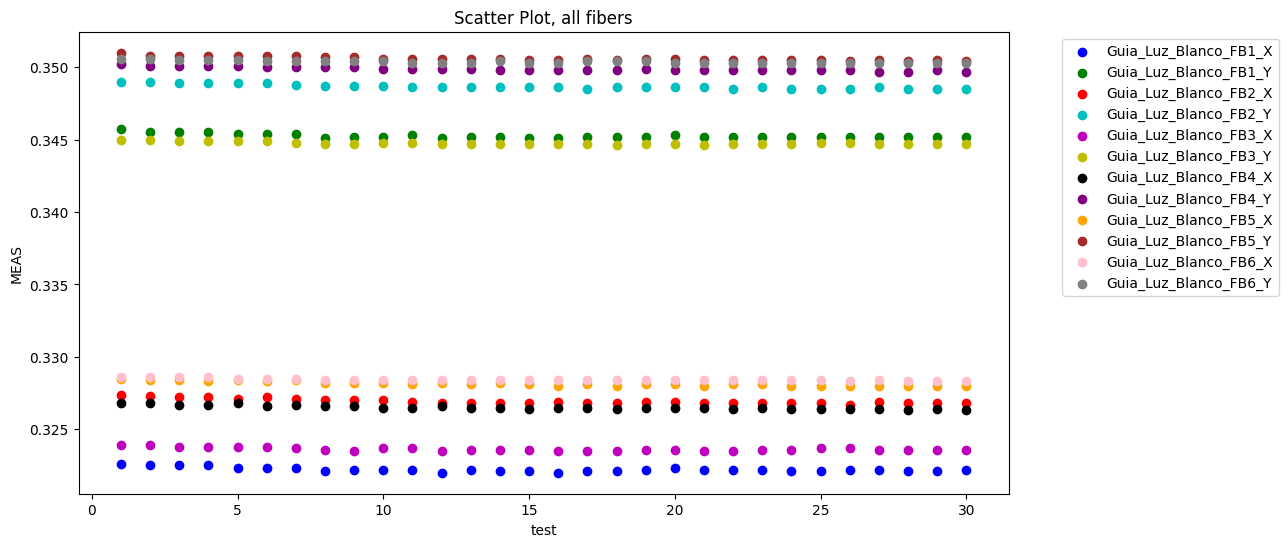

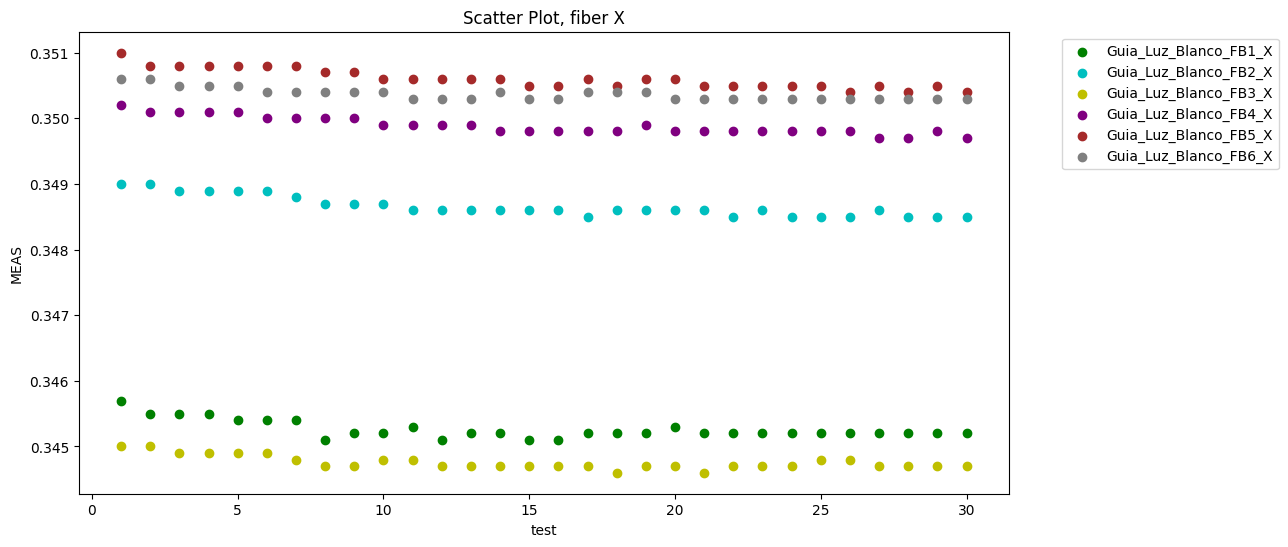

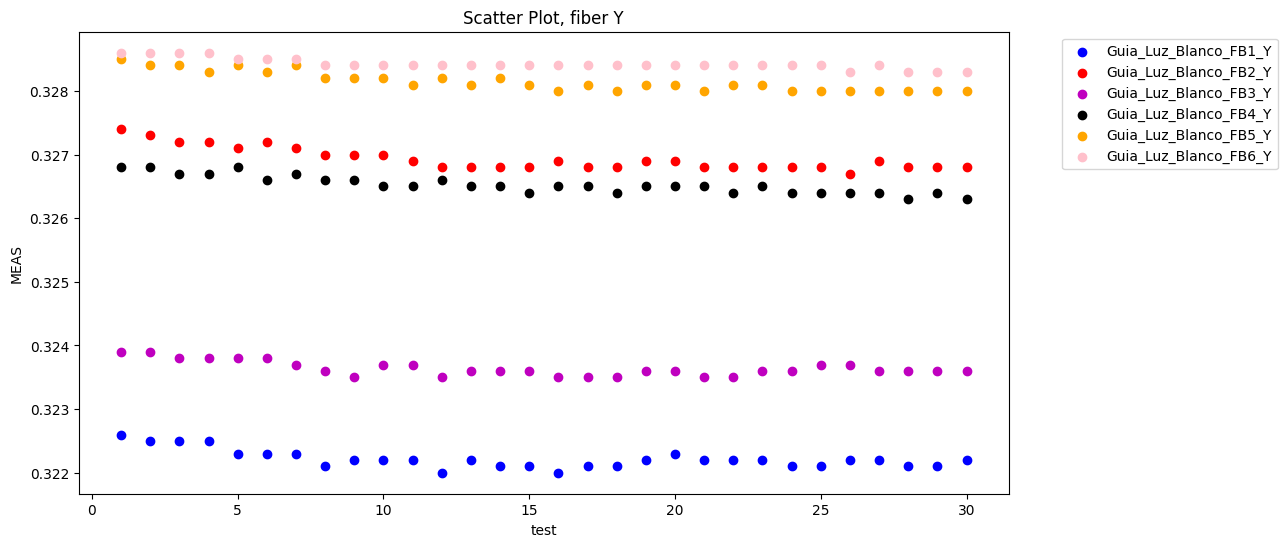

In [6]:
##Visualizations
plot_scatter(MEAS, title='Scatter Plot, all fibers', xlabel='test', ylabel='MEAS') #Plot all guides
plot_scatter(MEAS, title='Scatter Plot, fiber X', xlabel='test', ylabel='MEAS', filter='x') #Plot x axis values
plot_scatter(MEAS, title='Scatter Plot, fiber Y', xlabel='test', ylabel='MEAS', filter='y') #Plot y axis values

In [7]:
##Descriptive statistics
RESUME = MEAS.transpose().describe().transpose() #Transpose the df first due to describe() working in columns.
RESUME_format = rename_index(RESUME)
display(RESUME_format)

,count,mean,std,min,25%,50%,75%,max
Guia_Luz_Blanco_FB1_X,30.0,0.322213,0.000148,0.3220,0.322100,0.32220,0.322275,0.3226
Guia_Luz_Blanco_FB1_Y,30.0,0.345260,0.000143,0.3451,0.345200,0.34520,0.345300,0.3457
Guia_Luz_Blanco_FB2_X,30.0,0.326930,0.000180,0.3267,0.326800,0.32685,0.327000,0.3274
Guia_Luz_Blanco_FB2_Y,30.0,0.348657,0.000159,0.3485,0.348525,0.34860,0.348700,0.3490
Guia_Luz_Blanco_FB3_X,30.0,0.323640,0.000119,0.3235,0.323600,0.32360,0.323700,0.3239
Guia_Luz_Blanco_FB3_Y,30.0,0.344757,0.000104,0.3446,0.344700,0.34470,0.344800,0.3450
Guia_Luz_Blanco_FB4_X,30.0,0.326523,0.000141,0.3263,0.326400,0.32650,0.326600,0.3268
Guia_Luz_Blanco_FB4_Y,30.0,0.349887,0.000136,0.3497,0.349800,0.34980,0.350000,0.3502
Guia_Luz_Blanco_FB5_X,30.0,0.328150,0.000153,0.3280,0.328000,0.32810,0.328200,0.3285
Guia_Luz_Blanco_FB5_Y,30.0,0.350607,0.000148,0.3504,0.350500,0.35060,0.350700,0.3510


Analysis of faulty fibers

In [8]:
##Analysis of faulty fibers
std = pd.DataFrame(RESUME_format['std'])  #Get the std values
fiber_number = rename_index(pd.DataFrame(range(1, std.shape[0]+1))).rename(columns={0: 'Fiber number'}) #Add an absolute number for quick identification
largest = pd.concat([std, fiber_number], axis = 1).sort_values(by="std", ascending=False)[:5]  #Filter the 5 largest values
largest

,std,Fiber number
Guia_Luz_Blanco_FB2_X,0.000180,3
Guia_Luz_Blanco_FB2_Y,0.000159,4
Guia_Luz_Blanco_FB5_X,0.000153,9
Guia_Luz_Blanco_FB5_Y,0.000148,10
Guia_Luz_Blanco_FB1_X,0.000148,1


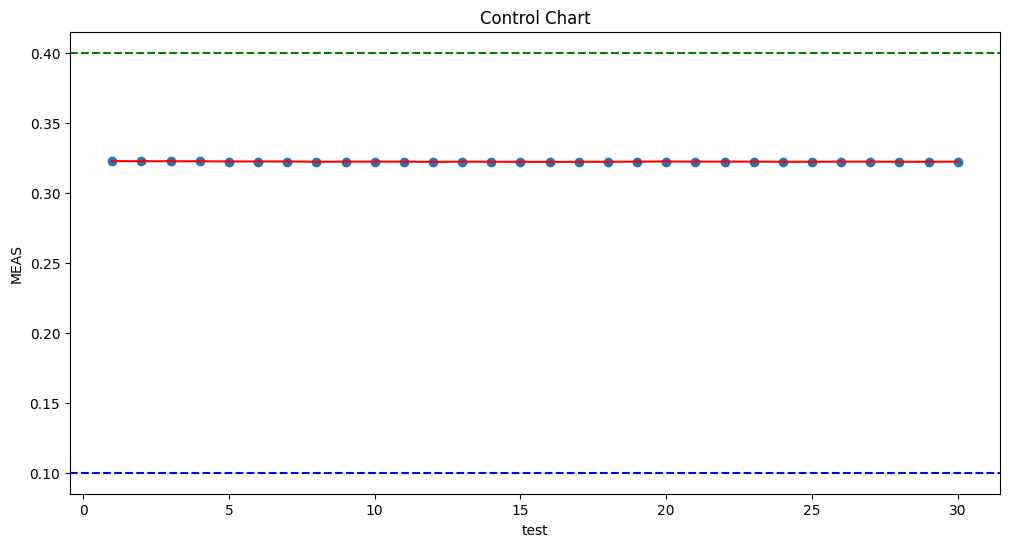

In [9]:
##Specific fibers visualization
yrange = position_chart(mean_slider, range_slider, auto_position_flag=auto_position.value)
display(HBox([fiber_selection, auto_position, mean_slider, range_slider]))
plot_control_chart(MEAS_format, title='Control Chart', xlabel='test', ylabel='MEAS', LIMITS=LIMITS, fiber=fiber_selection.value, yrange=yrange)

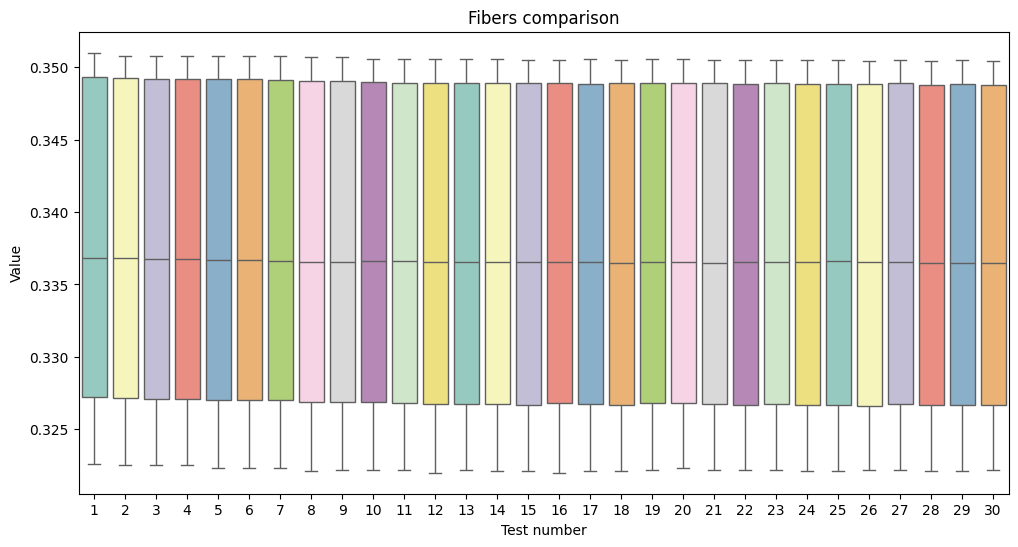

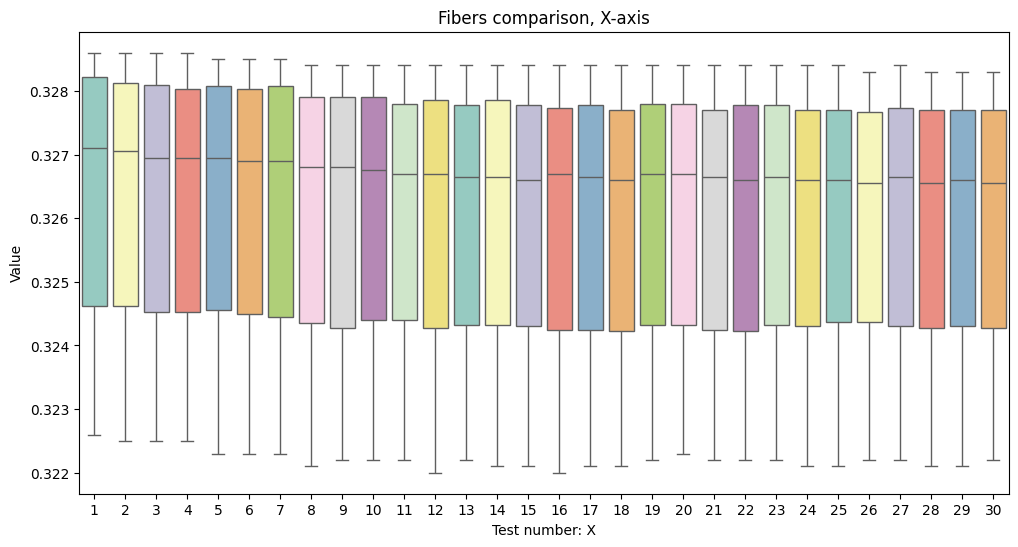

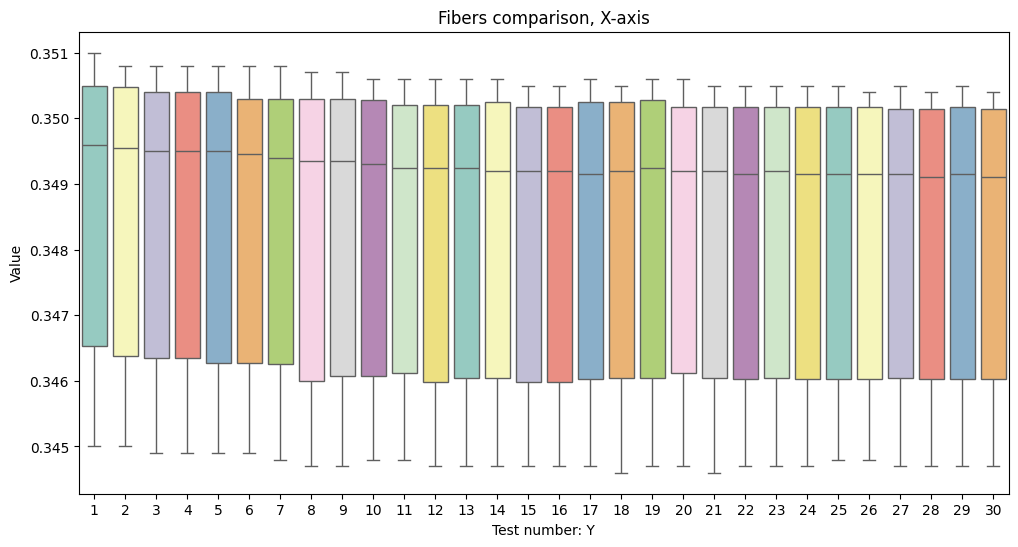

In [10]:
#Subgroups visualizations
plot_boxplot(MEAS_format, title="Fibers comparison", xlabel="Test number", ylabel="Value", filter=None)
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="X")
plot_boxplot(MEAS_format, title="Fibers comparison, X-axis", xlabel="Test number: ", ylabel="Value", filter="Y")

In [11]:
plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="X", lenses_per_nest=FIXTURE_DATA.iloc["lenses per nest"])
plot_boxplot(MEAS_format.transpose(), title="Fibers comparison", xlabel="Fibers group: ", ylabel="Value", filter="Y", lenses_per_nest=glob.lenses_per_nest)

TypeError: Cannot index by location index with a non-integer key

In [ ]:
FIXTURE_DATA.at["lenses per nest", "Tooling data"]

KeyError: 'lenses per nest'

In [12]:
FIXTURE_DATA

,Tooling data
0,VA-007
1,3
2,2
3,0.0125
4,0.0165
5,0.02
6,0.03
